In [1]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import tensorflow as tf

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood a

In [2]:
import tensorflow as tf
print(tf.__version__)

1.14.0


In [3]:
# Load the data
df = pd.read_csv("alldata36.csv", delimiter=',')
df['public_date'] = pd.to_datetime(df['public_date'])
df = df.sort_values(by=['permno', 'public_date'])

In [4]:
# Get unique company counts before filtering
initial_bankrupt_count = df[df['Bankrupt']].drop_duplicates('permno').shape[0]
initial_non_bankrupt_count = df[~df['Bankrupt']].drop_duplicates('permno').shape[0]

# Specify the periods, adjusted for zero-based index
periods = [x - 1 for x in range(3, 37, 3)]  # Simplified generation of periods

# Filter rows for each 'permno' based on the specified periods
filtered_df = df.groupby('permno').nth(periods).reset_index()

# Count unique bankrupt and non-bankrupt companies post-filtering
filtered_bankrupt_count = filtered_df[filtered_df['Bankrupt']].drop_duplicates('permno').shape[0]
filtered_non_bankrupt_count = filtered_df[~filtered_df['Bankrupt']].drop_duplicates('permno').shape[0]

# Print the initial and post-filtering counts
print(f"Initial Number of bankrupt companies: {initial_bankrupt_count}")
print(f"Initial Number of non-bankrupt companies: {initial_non_bankrupt_count}")
print(f"Filtered Number of bankrupt companies: {filtered_bankrupt_count}")
print(f"Filtered Number of non-bankrupt companies: {filtered_non_bankrupt_count}")

Initial Number of bankrupt companies: 2154
Initial Number of non-bankrupt companies: 13843
Filtered Number of bankrupt companies: 2154
Filtered Number of non-bankrupt companies: 13843


In [5]:
# Ratios based on Feature Selection using LASSO
ratios = ['capital_ratio', 'equity_invcap', 'debt_invcap', 'totdebt_invcap', 'at_turn',
         'inv_turn', 'pay_turn', 'rect_turn', 'sale_equity', 'sale_invcap', 'sale_nwc',
         'invt_act', 'rect_act', 'fcf_ocf', 'ocf_lct', 'cash_debt', 'cash_lt', 'cfm',
         'short_debt', 'profit_lct', 'curr_debt', 'debt_ebitda', 'dltt_be', 'int_debt',
         'int_totdebt', 'lt_debt', 'lt_ppent', 'cash_conversion', 'cash_ratio', 'curr_ratio',
         'quick_ratio', 'accrual', 'rd_sale', 'adv_sale', 'staff_sale', 'efftax', 'gprof',
         'aftret_eq', 'aftret_equity', 'aftret_invcapx', 'gpm', 'npm', 'opmad', 'opmbd',
         'pretret_earnat', 'pretret_noa', 'ptpm', 'roa', 'roce', 'roe', 'de_ratio',
         'debt_assets', 'debt_at', 'debt_capital', 'intcov', 'intcov_ratio', 'dpr', 'bm',
         'capei', 'divyield', 'evm', 'pcf', 'pe_exi', 'pe_inc', 'pe_op_basic', 'pe_op_dil',
         'ps', 'ptb', 'peg_1yrforward', 'peg_ltgforward', 'peg_trailing']

In [6]:
# Prepare the dataset for LSTM
X, y, permnos = [], [], []
grouped = df.groupby('permno')

sequence_length = 12
for permno, group in grouped:
    group = group.sort_values(by='public_date')  # Ensure sorting by date
    if len(group) >= sequence_length:
        X.append(group[ratios].tail(sequence_length).values)
        y.append(group['Bankrupt'].iloc[-1])
        permnos.append(permno)  # Store permno for later use

X, y = np.array(X), np.array(y)

In [7]:
# Impute missing values
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)


In [8]:
# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)


In [9]:
from tensorflow.keras.models import load_model

In [10]:
# Load the model
model = load_model('LSTM_Model_72_Q36.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [11]:
# Prepare a subset of the training data 
background_data = X_scaled[:1000]

# Initialize the SHAP DeepExplainer with the model and the background data
explainer = shap.DeepExplainer(model, background_data)

# Prepare a subset of test data for which you want explanations
test_data_for_explanation = X_scaled

Using TensorFlow backend.
keras is no longer supported, please use tf.keras instead.


In [12]:
# Calculate SHAP values for the selected test data
shap_values = explainer.shap_values(test_data_for_explanation)

# Assuming the model outputs SHAP values for each class and is a classification model
selected_class_index = 0  # Assuming the bankrupt class is at index 1
shap_values_for_class = shap_values[selected_class_index]


Adjusted SHAP values shape: (15997, 71)
Adjusted test data shape: (15997, 71)


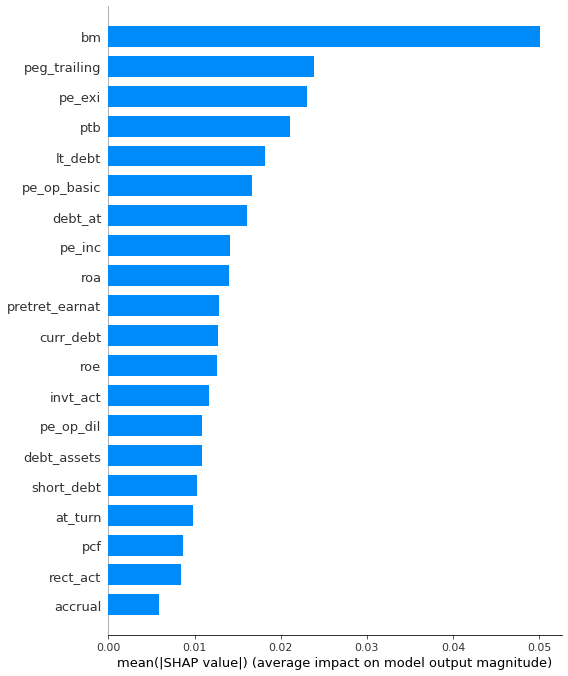

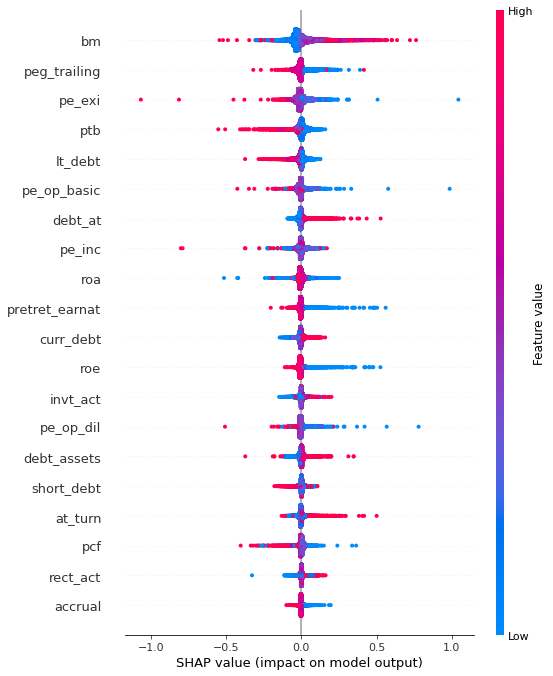

Successfully generated SHAP summary plot for bankrupt class.


In [12]:
# For LSTM or models where input is sequence data, we want to focus on the last timestep for SHAP values
# This focuses on the last timestep's SHAP values if the model is an LSTM
if len(shap_values_for_class.shape) == 3:
    shap_values_last_timestep = shap_values_for_class[:, -1, :]
    test_data_last_timestep = test_data_for_explanation[:, -1, :]
else:
    shap_values_last_timestep = shap_values_for_class
    test_data_last_timestep = test_data_for_explanation

# Print shapes to confirm the adjustment
print("Adjusted SHAP values shape:", shap_values_last_timestep.shape)
print("Adjusted test data shape:", test_data_last_timestep.shape)

# Try plotting again with matched number of rows
try:
    shap.summary_plot(shap_values_last_timestep, test_data_last_timestep, feature_names=ratios, plot_type='bar')
    shap.summary_plot(shap_values_last_timestep, test_data_last_timestep, feature_names=ratios)
    print("Successfully generated SHAP summary plot for bankrupt class.")
except Exception as e:
    print("Error in generating SHAP summary plot for bankrupt class:", e)


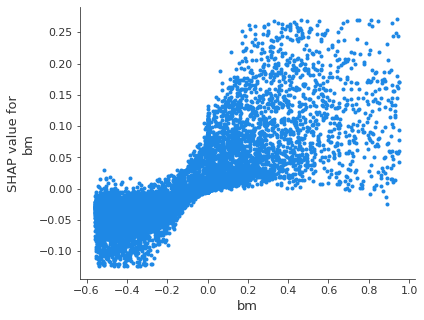

Successfully generated SHAP dependence plot for bm.


In [14]:
# For LSTM or models where input is sequence data, we want to focus on the last timestep for SHAP values
if len(shap_values_for_class.shape) == 3:
    shap_values_last_timestep = shap_values_for_class[:, -1, :]
    test_data_last_timestep = test_data_for_explanation[:, -1, :]
else:
    shap_values_last_timestep = shap_values_for_class
    test_data_last_timestep = test_data_for_explanation

# Function to remove outliers using quantiles
def remove_outliers(values, low_quantile=0.01, high_quantile=0.99):
    lower_bound = np.quantile(values, low_quantile)
    upper_bound = np.quantile(values, high_quantile)
    mask = (values >= lower_bound) & (values <= upper_bound)
    return mask

# Select a feature for the dependence plot
feature_to_plot = 'bm'
feature_index = ratios.index(feature_to_plot)

# Remove outliers based on the `bm` feature itself
bm_values = test_data_last_timestep[:, feature_index]
mask_bm = remove_outliers(bm_values, 0.05, 0.95)
filtered_bm_values = bm_values[mask_bm]
filtered_test_data = test_data_last_timestep[mask_bm]
filtered_shap_values = shap_values_last_timestep[mask_bm]

# Further filter outliers from SHAP values themselves
mask_shap = remove_outliers(filtered_shap_values[:, feature_index], 0.01, 0.99)
final_filtered_shap_values = filtered_shap_values[mask_shap]
final_filtered_test_data = filtered_test_data[mask_shap]

# Create the SHAP dependence plot
try:
    shap.dependence_plot(
        feature_to_plot,                           # Feature to plot
        final_filtered_shap_values,                # SHAP values for the selected class (outliers removed)
        final_filtered_test_data,                  # Corresponding features from the test data (outliers removed)
        feature_names=ratios,                      # Names of the features
        interaction_index=None                     # Set to None for no interaction, or specify another feature name
    )
    print(f"Successfully generated SHAP dependence plot for {feature_to_plot}.")
except Exception as e:
    print(f"Error in generating SHAP dependence plot for {feature_to_plot}:", e)

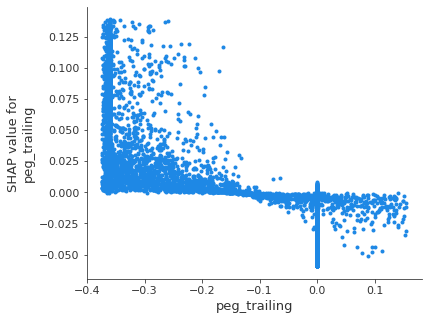

Successfully generated SHAP dependence plot for peg_trailing.


In [15]:
# Select a feature for the dependence plot
feature_to_plot = 'peg_trailing'
feature_index = ratios.index(feature_to_plot)

# Remove outliers based on the `bm` feature itself
bm_values = test_data_last_timestep[:, feature_index]
mask_bm = remove_outliers(bm_values, 0.05, 0.95)
filtered_bm_values = bm_values[mask_bm]
filtered_test_data = test_data_last_timestep[mask_bm]
filtered_shap_values = shap_values_last_timestep[mask_bm]

# Further filter outliers from SHAP values themselves
mask_shap = remove_outliers(filtered_shap_values[:, feature_index], 0.01, 0.99)
final_filtered_shap_values = filtered_shap_values[mask_shap]
final_filtered_test_data = filtered_test_data[mask_shap]

# Create the SHAP dependence plot
try:
    shap.dependence_plot(
        feature_to_plot,                           # Feature to plot
        final_filtered_shap_values,                # SHAP values for the selected class (outliers removed)
        final_filtered_test_data,                  # Corresponding features from the test data (outliers removed)
        feature_names=ratios,                      # Names of the features
        interaction_index=None                     # Set to None for no interaction, or specify another feature name
    )
    print(f"Successfully generated SHAP dependence plot for {feature_to_plot}.")
except Exception as e:
    print(f"Error in generating SHAP dependence plot for {feature_to_plot}:", e)

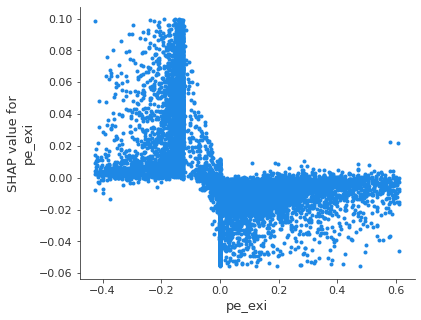

Successfully generated SHAP dependence plot for pe_exi.


In [16]:
# Select a feature for the dependence plot
feature_to_plot = 'pe_exi'
feature_index = ratios.index(feature_to_plot)

# Remove outliers based on the `bm` feature itself
bm_values = test_data_last_timestep[:, feature_index]
mask_bm = remove_outliers(bm_values, 0.05, 0.95)
filtered_bm_values = bm_values[mask_bm]
filtered_test_data = test_data_last_timestep[mask_bm]
filtered_shap_values = shap_values_last_timestep[mask_bm]

# Further filter outliers from SHAP values themselves
mask_shap = remove_outliers(filtered_shap_values[:, feature_index], 0.01, 0.99)
final_filtered_shap_values = filtered_shap_values[mask_shap]
final_filtered_test_data = filtered_test_data[mask_shap]

# Create the SHAP dependence plot
try:
    shap.dependence_plot(
        feature_to_plot,                           # Feature to plot
        final_filtered_shap_values,                # SHAP values for the selected class (outliers removed)
        final_filtered_test_data,                  # Corresponding features from the test data (outliers removed)
        feature_names=ratios,                      # Names of the features
        interaction_index=None                     # Set to None for no interaction, or specify another feature name
    )
    print(f"Successfully generated SHAP dependence plot for {feature_to_plot}.")
except Exception as e:
    print(f"Error in generating SHAP dependence plot for {feature_to_plot}:", e)

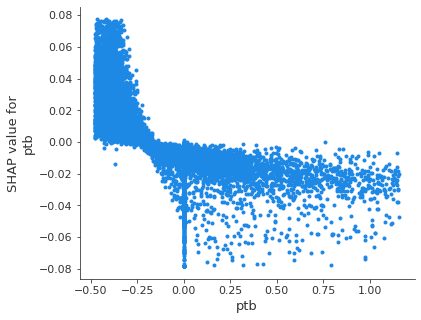

Successfully generated SHAP dependence plot for ptb.


In [17]:
# Select a feature for the dependence plot
feature_to_plot = 'ptb'
feature_index = ratios.index(feature_to_plot)

# Remove outliers based on the `bm` feature itself
bm_values = test_data_last_timestep[:, feature_index]
mask_bm = remove_outliers(bm_values, 0.05, 0.95)
filtered_bm_values = bm_values[mask_bm]
filtered_test_data = test_data_last_timestep[mask_bm]
filtered_shap_values = shap_values_last_timestep[mask_bm]

# Further filter outliers from SHAP values themselves
mask_shap = remove_outliers(filtered_shap_values[:, feature_index], 0.01, 0.99)
final_filtered_shap_values = filtered_shap_values[mask_shap]
final_filtered_test_data = filtered_test_data[mask_shap]

# Create the SHAP dependence plot
try:
    shap.dependence_plot(
        feature_to_plot,                           # Feature to plot
        final_filtered_shap_values,                # SHAP values for the selected class (outliers removed)
        final_filtered_test_data,                  # Corresponding features from the test data (outliers removed)
        feature_names=ratios,                      # Names of the features
        interaction_index=None                     # Set to None for no interaction, or specify another feature name
    )
    print(f"Successfully generated SHAP dependence plot for {feature_to_plot}.")
except Exception as e:
    print(f"Error in generating SHAP dependence plot for {feature_to_plot}:", e)

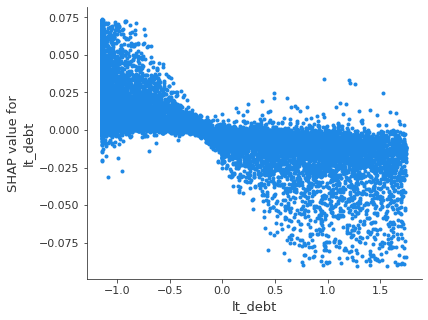

Successfully generated SHAP dependence plot for lt_debt.


In [18]:
# Select a feature for the dependence plot
feature_to_plot = 'lt_debt'
feature_index = ratios.index(feature_to_plot)

# Remove outliers based on the `bm` feature itself
bm_values = test_data_last_timestep[:, feature_index]
mask_bm = remove_outliers(bm_values, 0.05, 0.95)
filtered_bm_values = bm_values[mask_bm]
filtered_test_data = test_data_last_timestep[mask_bm]
filtered_shap_values = shap_values_last_timestep[mask_bm]

# Further filter outliers from SHAP values themselves
mask_shap = remove_outliers(filtered_shap_values[:, feature_index], 0.01, 0.99)
final_filtered_shap_values = filtered_shap_values[mask_shap]
final_filtered_test_data = filtered_test_data[mask_shap]

# Create the SHAP dependence plot
try:
    shap.dependence_plot(
        feature_to_plot,                           # Feature to plot
        final_filtered_shap_values,                # SHAP values for the selected class (outliers removed)
        final_filtered_test_data,                  # Corresponding features from the test data (outliers removed)
        feature_names=ratios,                      # Names of the features
        interaction_index=None                     # Set to None for no interaction, or specify another feature name
    )
    print(f"Successfully generated SHAP dependence plot for {feature_to_plot}.")
except Exception as e:
    print(f"Error in generating SHAP dependence plot for {feature_to_plot}:", e)

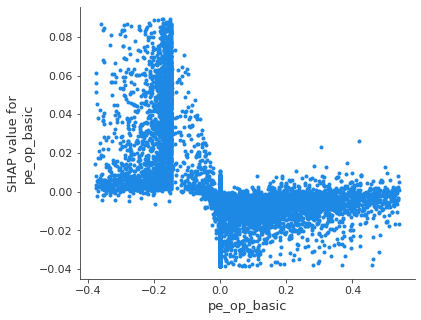

Successfully generated SHAP dependence plot for pe_op_basic.


In [19]:
# Select a feature for the dependence plot
feature_to_plot = 'pe_op_basic'
feature_index = ratios.index(feature_to_plot)

# Remove outliers based on the `bm` feature itself
bm_values = test_data_last_timestep[:, feature_index]
mask_bm = remove_outliers(bm_values, 0.05, 0.95)
filtered_bm_values = bm_values[mask_bm]
filtered_test_data = test_data_last_timestep[mask_bm]
filtered_shap_values = shap_values_last_timestep[mask_bm]

# Further filter outliers from SHAP values themselves
mask_shap = remove_outliers(filtered_shap_values[:, feature_index], 0.01, 0.99)
final_filtered_shap_values = filtered_shap_values[mask_shap]
final_filtered_test_data = filtered_test_data[mask_shap]

# Create the SHAP dependence plot
try:
    shap.dependence_plot(
        feature_to_plot,                           # Feature to plot
        final_filtered_shap_values,                # SHAP values for the selected class (outliers removed)
        final_filtered_test_data,                  # Corresponding features from the test data (outliers removed)
        feature_names=ratios,                      # Names of the features
        interaction_index=None                     # Set to None for no interaction, or specify another feature name
    )
    print(f"Successfully generated SHAP dependence plot for {feature_to_plot}.")
except Exception as e:
    print(f"Error in generating SHAP dependence plot for {feature_to_plot}:", e)

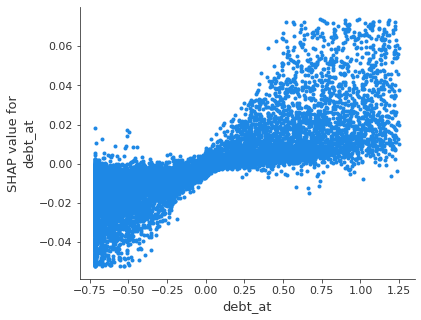

Successfully generated SHAP dependence plot for debt_at.


In [20]:
# Select a feature for the dependence plot
feature_to_plot = 'debt_at'
feature_index = ratios.index(feature_to_plot)

# Remove outliers based on the `bm` feature itself
bm_values = test_data_last_timestep[:, feature_index]
mask_bm = remove_outliers(bm_values, 0.05, 0.95)
filtered_bm_values = bm_values[mask_bm]
filtered_test_data = test_data_last_timestep[mask_bm]
filtered_shap_values = shap_values_last_timestep[mask_bm]

# Further filter outliers from SHAP values themselves
mask_shap = remove_outliers(filtered_shap_values[:, feature_index], 0.01, 0.99)
final_filtered_shap_values = filtered_shap_values[mask_shap]
final_filtered_test_data = filtered_test_data[mask_shap]

# Create the SHAP dependence plot
try:
    shap.dependence_plot(
        feature_to_plot,                           # Feature to plot
        final_filtered_shap_values,                # SHAP values for the selected class (outliers removed)
        final_filtered_test_data,                  # Corresponding features from the test data (outliers removed)
        feature_names=ratios,                      # Names of the features
        interaction_index=None                     # Set to None for no interaction, or specify another feature name
    )
    print(f"Successfully generated SHAP dependence plot for {feature_to_plot}.")
except Exception as e:
    print(f"Error in generating SHAP dependence plot for {feature_to_plot}:", e)

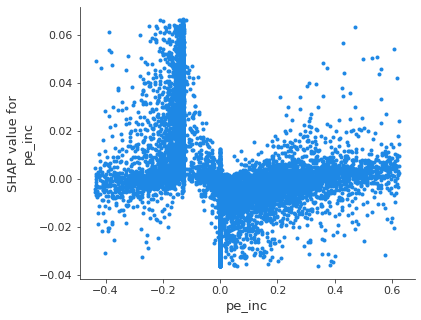

Successfully generated SHAP dependence plot for pe_inc.


In [21]:
# Select a feature for the dependence plot
feature_to_plot = 'pe_inc'
feature_index = ratios.index(feature_to_plot)

# Remove outliers based on the `bm` feature itself
bm_values = test_data_last_timestep[:, feature_index]
mask_bm = remove_outliers(bm_values, 0.05, 0.95)
filtered_bm_values = bm_values[mask_bm]
filtered_test_data = test_data_last_timestep[mask_bm]
filtered_shap_values = shap_values_last_timestep[mask_bm]

# Further filter outliers from SHAP values themselves
mask_shap = remove_outliers(filtered_shap_values[:, feature_index], 0.01, 0.99)
final_filtered_shap_values = filtered_shap_values[mask_shap]
final_filtered_test_data = filtered_test_data[mask_shap]

# Create the SHAP dependence plot
try:
    shap.dependence_plot(
        feature_to_plot,                           # Feature to plot
        final_filtered_shap_values,                # SHAP values for the selected class (outliers removed)
        final_filtered_test_data,                  # Corresponding features from the test data (outliers removed)
        feature_names=ratios,                      # Names of the features
        interaction_index=None                     # Set to None for no interaction, or specify another feature name
    )
    print(f"Successfully generated SHAP dependence plot for {feature_to_plot}.")
except Exception as e:
    print(f"Error in generating SHAP dependence plot for {feature_to_plot}:", e)

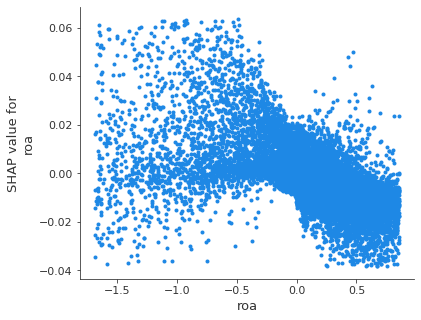

Successfully generated SHAP dependence plot for roa.


In [22]:
# Select a feature for the dependence plot
feature_to_plot = 'roa'
feature_index = ratios.index(feature_to_plot)

# Remove outliers based on the `bm` feature itself
bm_values = test_data_last_timestep[:, feature_index]
mask_bm = remove_outliers(bm_values, 0.05, 0.95)
filtered_bm_values = bm_values[mask_bm]
filtered_test_data = test_data_last_timestep[mask_bm]
filtered_shap_values = shap_values_last_timestep[mask_bm]

# Further filter outliers from SHAP values themselves
mask_shap = remove_outliers(filtered_shap_values[:, feature_index], 0.01, 0.99)
final_filtered_shap_values = filtered_shap_values[mask_shap]
final_filtered_test_data = filtered_test_data[mask_shap]

# Create the SHAP dependence plot
try:
    shap.dependence_plot(
        feature_to_plot,                           # Feature to plot
        final_filtered_shap_values,                # SHAP values for the selected class (outliers removed)
        final_filtered_test_data,                  # Corresponding features from the test data (outliers removed)
        feature_names=ratios,                      # Names of the features
        interaction_index=None                     # Set to None for no interaction, or specify another feature name
    )
    print(f"Successfully generated SHAP dependence plot for {feature_to_plot}.")
except Exception as e:
    print(f"Error in generating SHAP dependence plot for {feature_to_plot}:", e)

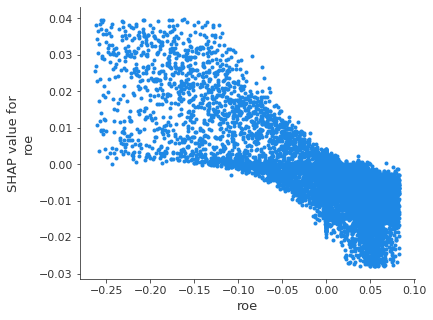

Successfully generated SHAP dependence plot for roe.


In [16]:
# Select a feature for the dependence plot
feature_to_plot = 'roe'
feature_index = ratios.index(feature_to_plot)

# Remove outliers based on the `bm` feature itself
bm_values = test_data_last_timestep[:, feature_index]
mask_bm = remove_outliers(bm_values, 0.05, 0.95)
filtered_bm_values = bm_values[mask_bm]
filtered_test_data = test_data_last_timestep[mask_bm]
filtered_shap_values = shap_values_last_timestep[mask_bm]

# Further filter outliers from SHAP values themselves
mask_shap = remove_outliers(filtered_shap_values[:, feature_index], 0.01, 0.99)
final_filtered_shap_values = filtered_shap_values[mask_shap]
final_filtered_test_data = filtered_test_data[mask_shap]

# Create the SHAP dependence plot
try:
    shap.dependence_plot(
        feature_to_plot,                           # Feature to plot
        final_filtered_shap_values,                # SHAP values for the selected class (outliers removed)
        final_filtered_test_data,                  # Corresponding features from the test data (outliers removed)
        feature_names=ratios,                      # Names of the features
        interaction_index=None                     # Set to None for no interaction, or specify another feature name
    )
    print(f"Successfully generated SHAP dependence plot for {feature_to_plot}.")
except Exception as e:
    print(f"Error in generating SHAP dependence plot for {feature_to_plot}:", e)

In [13]:
# For LSTM models, extract the SHAP values for the last timestep
shap_values_for_class = np.array([sv[-1] for sv in shap_values[0]])

# Print shapes to confirm the adjustment
print("Adjusted SHAP values shape:", shap_values_for_class.shape)


Adjusted SHAP values shape: (15997, 71)


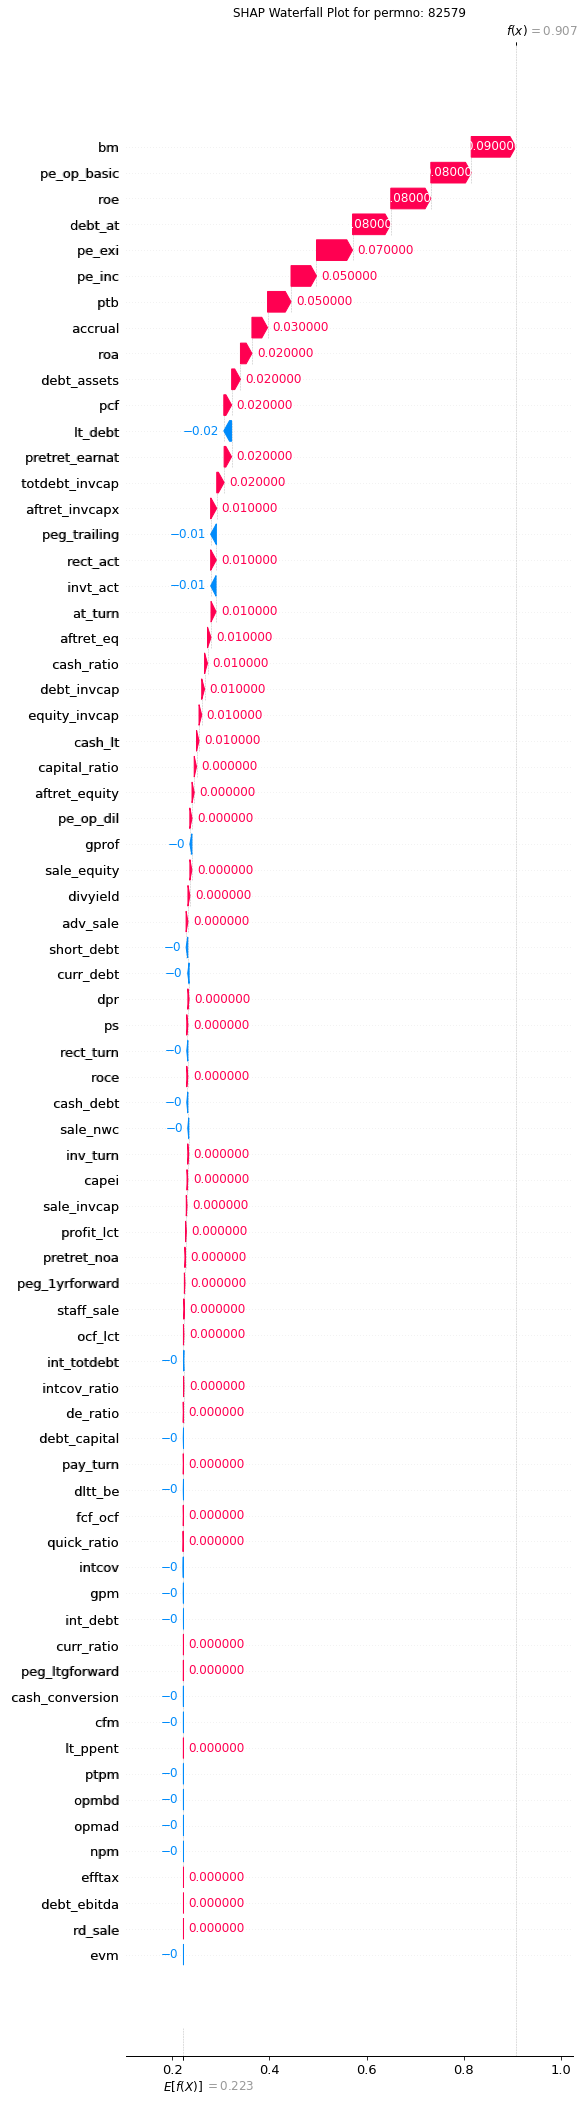

Successfully generated SHAP waterfall plot for permno: 82579


In [30]:
desired_permno = 82579  # Set the desired permno here

# Function to format the bar values with more precision
def format_bar_labels(ax, precision=4):
    for text in ax.texts:
        try:
            # Check if the text is a number and format it
            value = float(text.get_text())
            text.set_text(f'{value:.{precision}f}')
        except ValueError:
            continue

# Find the index of the desired permno in the test_permnos list
if desired_permno in permnos:
    instance_index = permnos.index(desired_permno)
    try:
        shap.initjs()  # Initialize JavaScript visualization in Jupyter notebook

        # Convert the SHAP values to an Explanation object
        feature_data = pd.DataFrame(test_data_for_explanation[instance_index], columns=ratios)
        explanation = shap.Explanation(values=shap_values_for_class[instance_index],
                                       base_values=explainer.expected_value[0],  # Assuming single output model
                                       data=feature_data.iloc[0],
                                       feature_names=ratios)

        # Plotting the waterfall chart
        fig, ax = plt.subplots()
        shap.plots.waterfall(explanation, show=False, max_display=len(ratios))

        # Get current y-tick labels
        yticklabels = ax.get_yticklabels()
        # Extract feature names without the numbers
        new_labels = [label.get_text().split('=')[1].strip() if '=' in label.get_text() else label.get_text() for label in yticklabels]
        
        # Apply new labels
        ax.set_yticklabels(new_labels)

        # Format the bar labels to show more precision
        format_bar_labels(ax, precision=6)

        plt.title(f'SHAP Waterfall Plot for permno: {desired_permno}')  # Display permno in the plot title
        plt.show()
        print("Successfully generated SHAP waterfall plot for permno:", desired_permno)
    except Exception as e:
        print("Error in generating SHAP waterfall plot for permno:", desired_permno, ":", e)
else:
    print("Permno", desired_permno, "not found in the test data.")

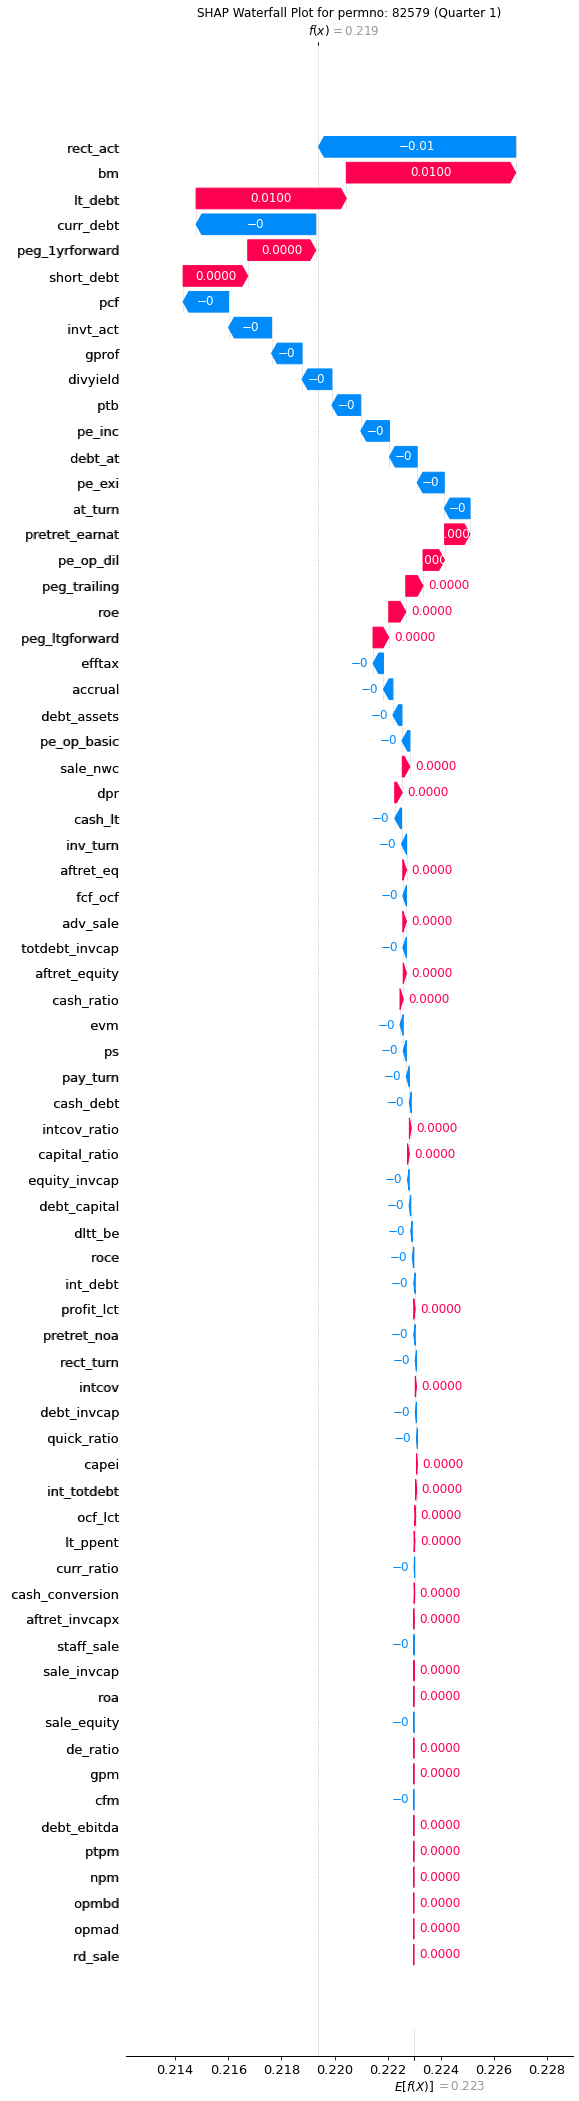

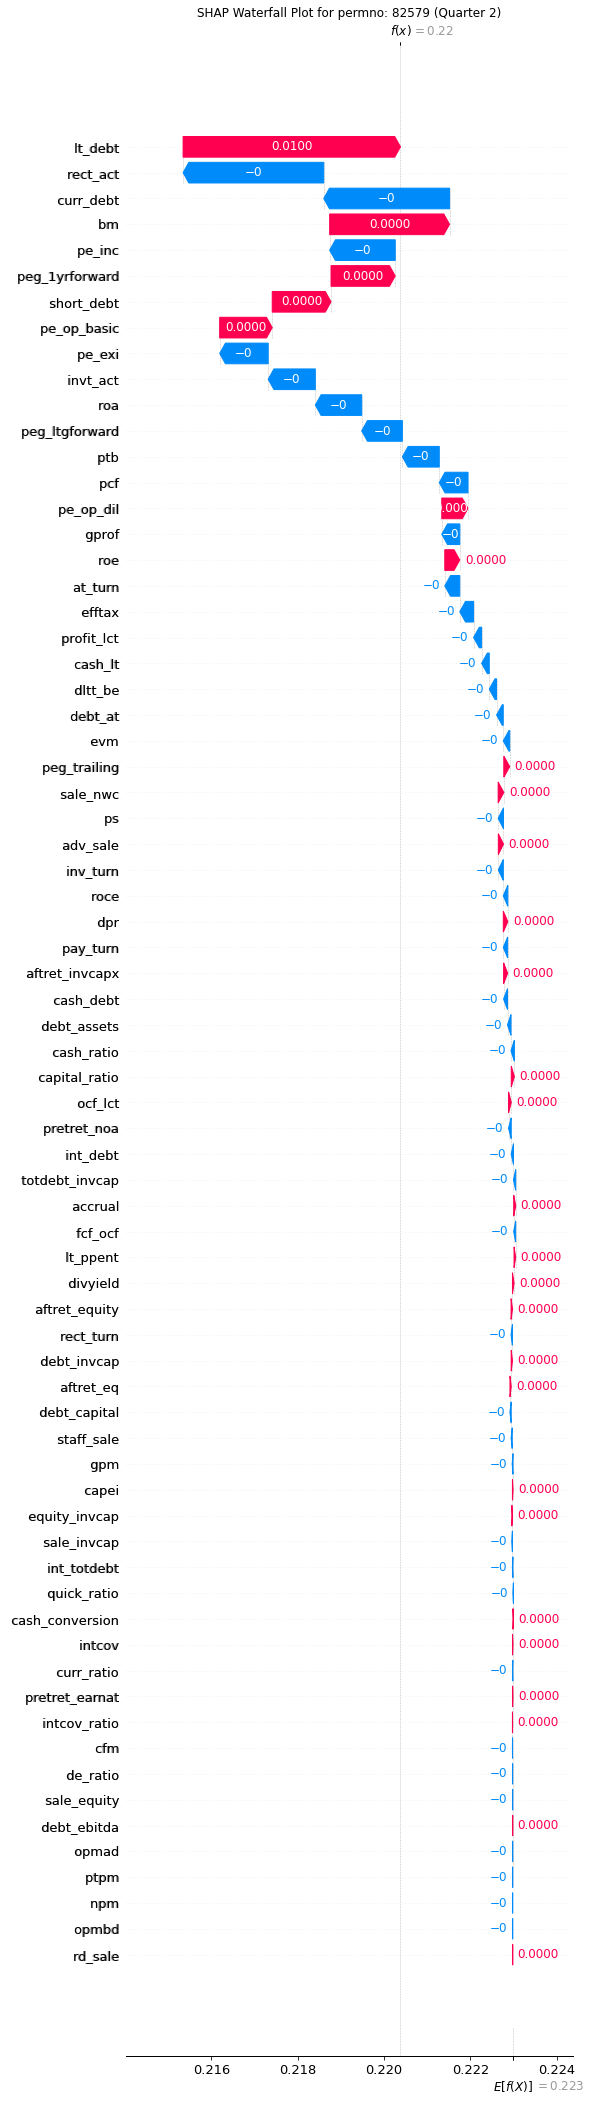

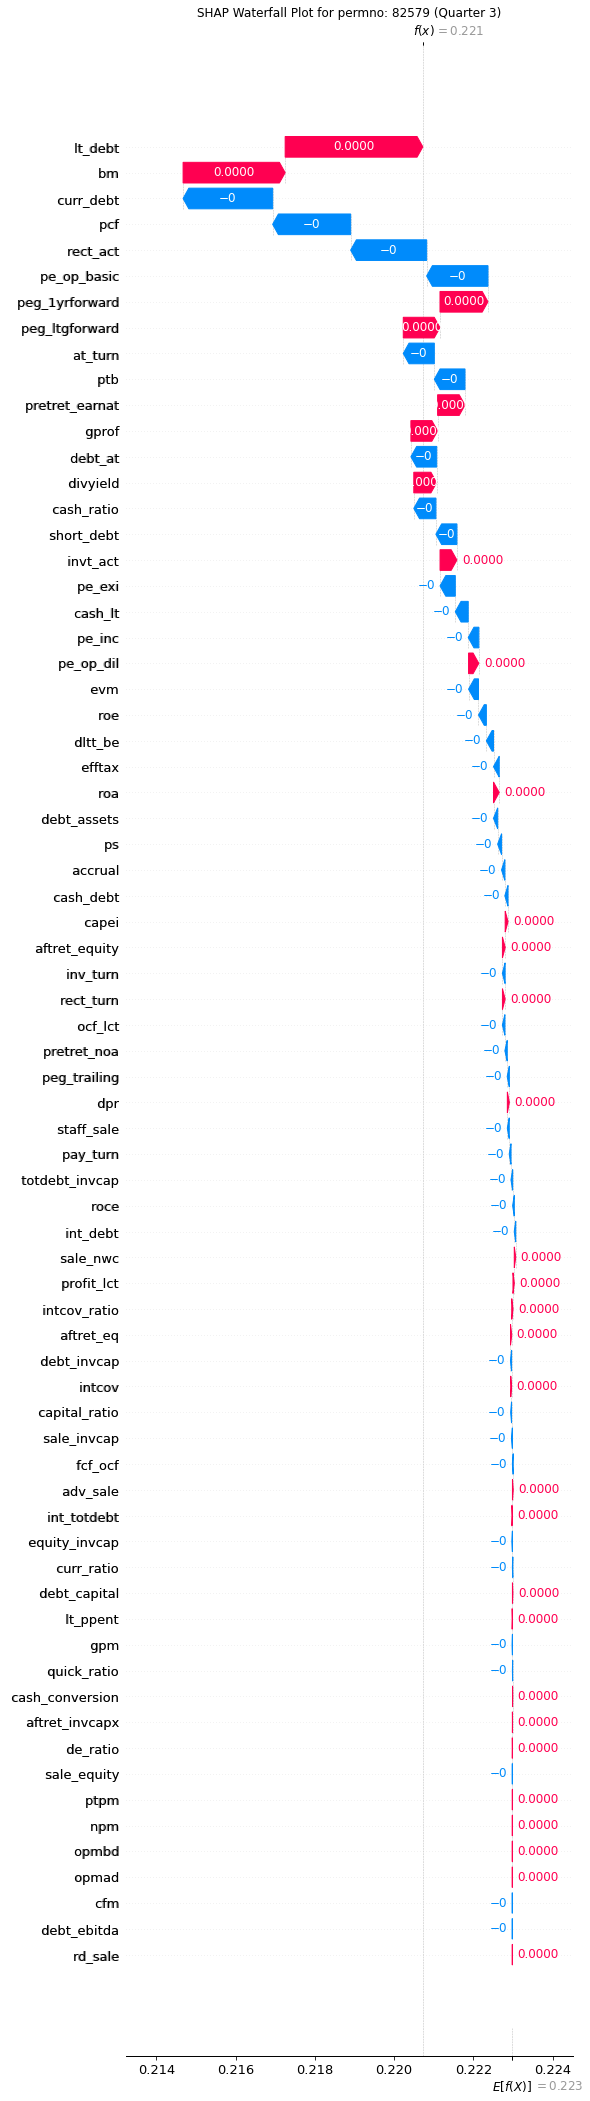

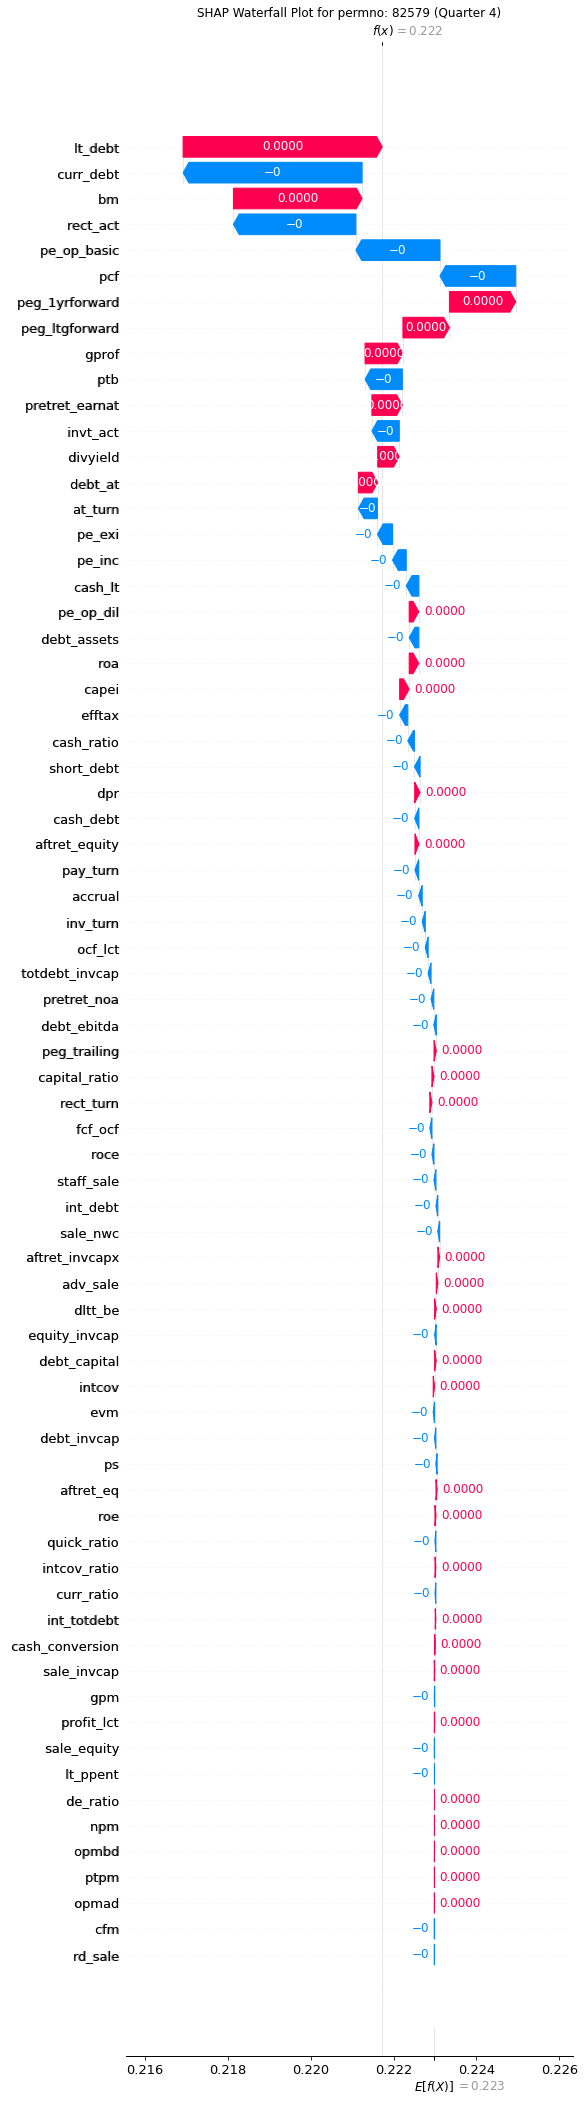

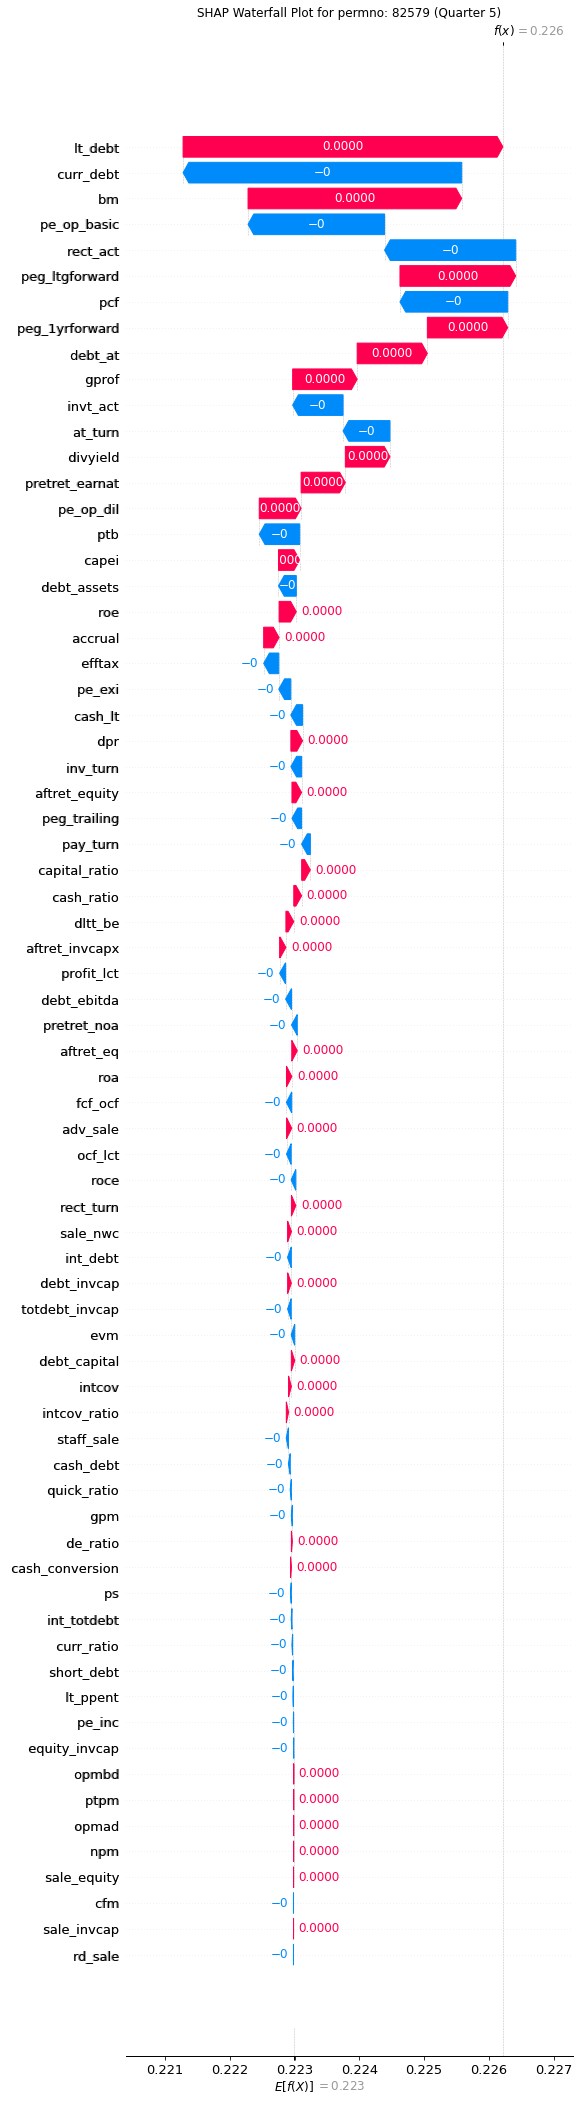

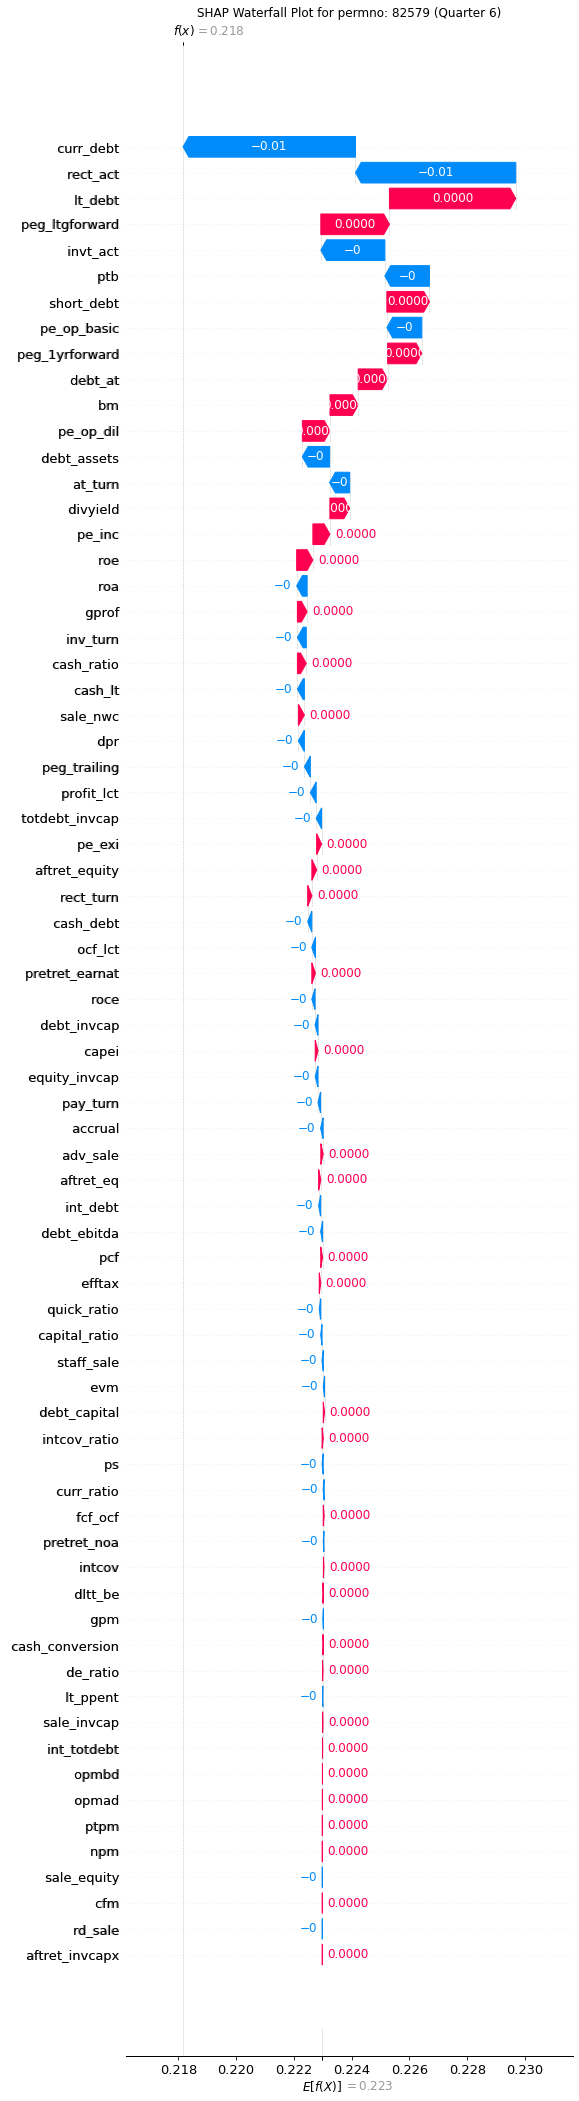

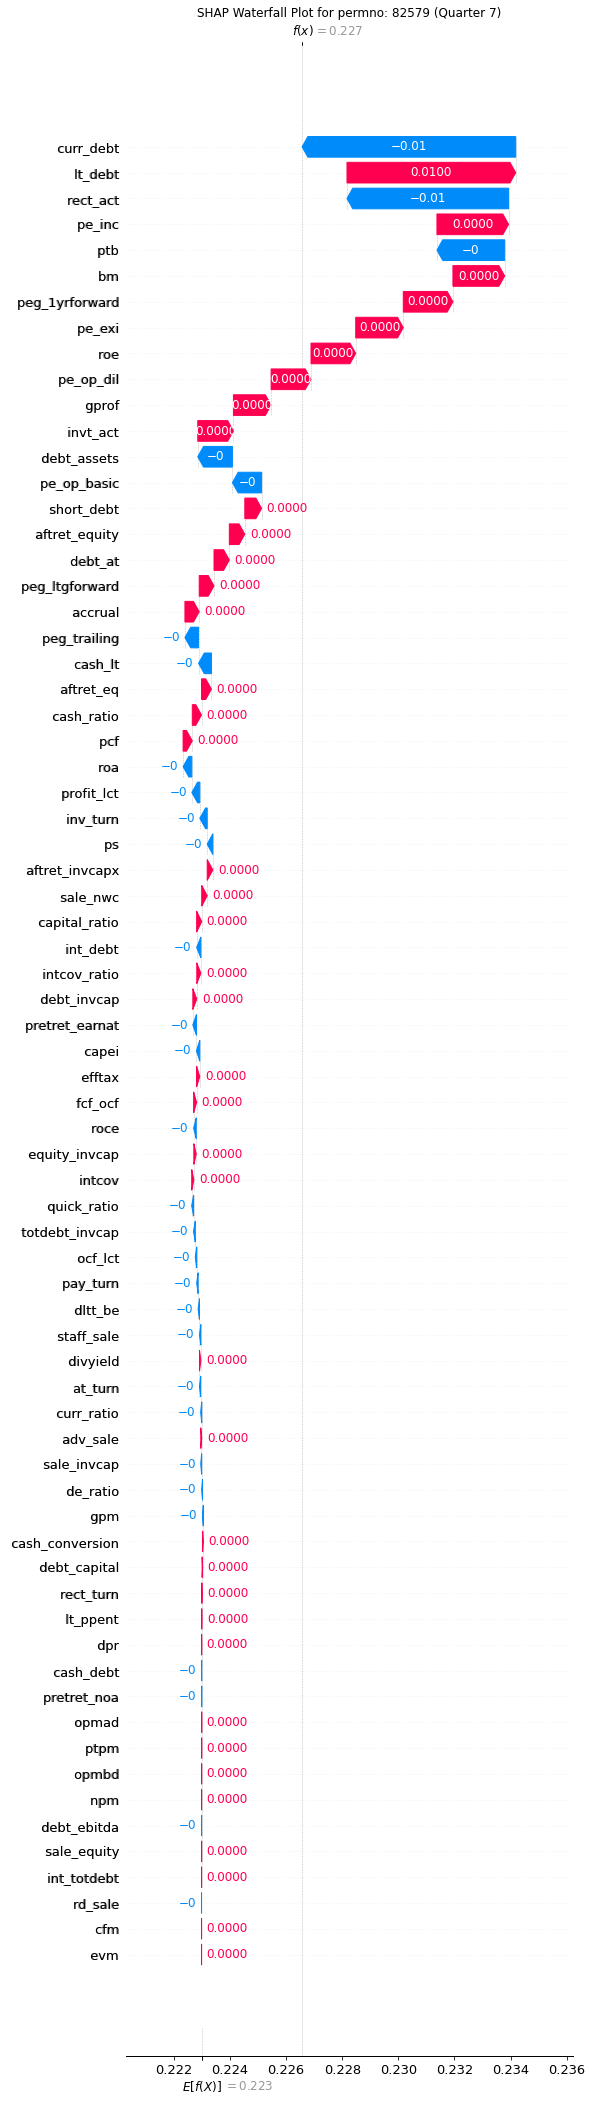

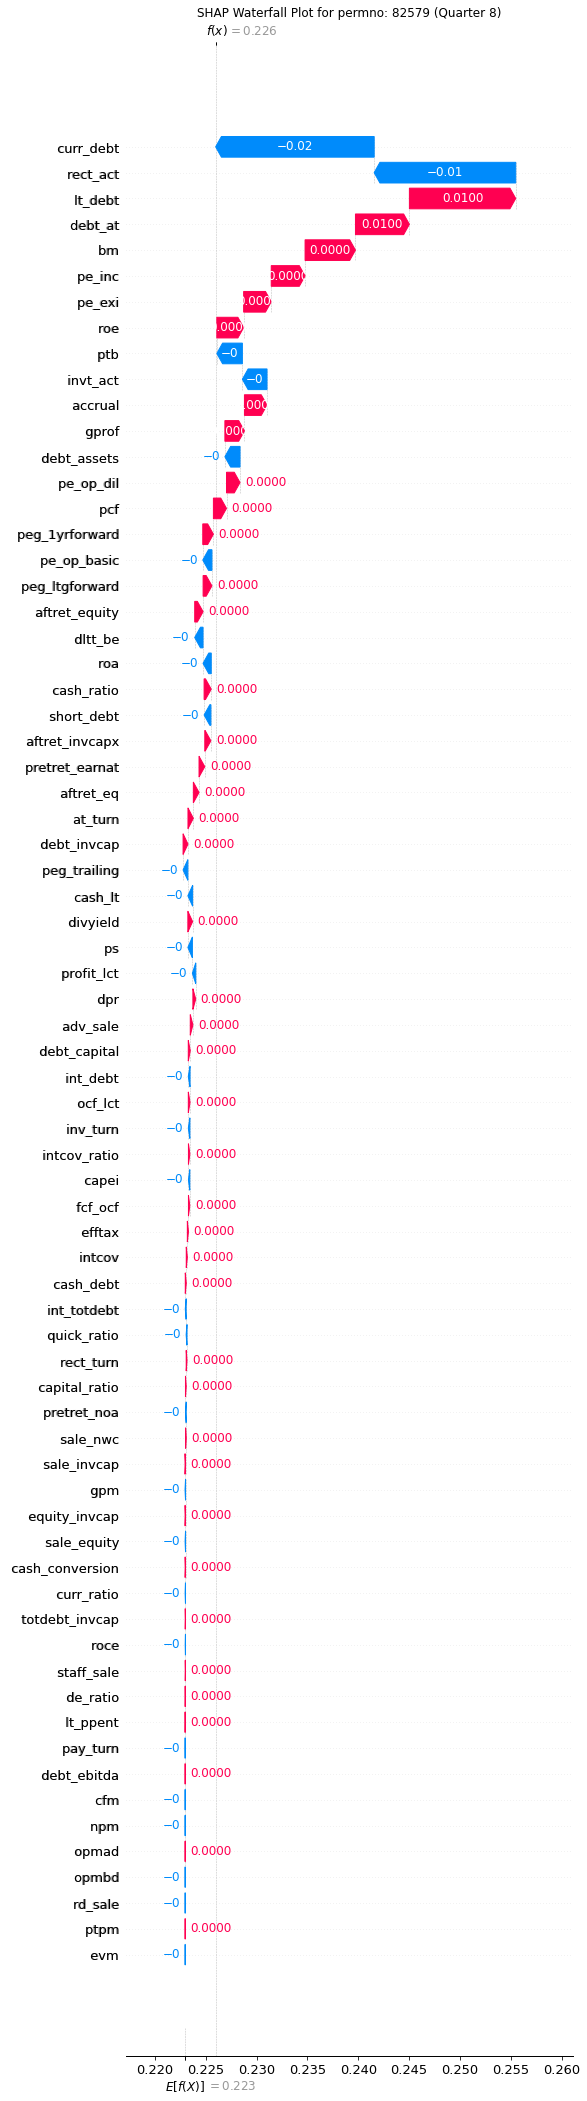

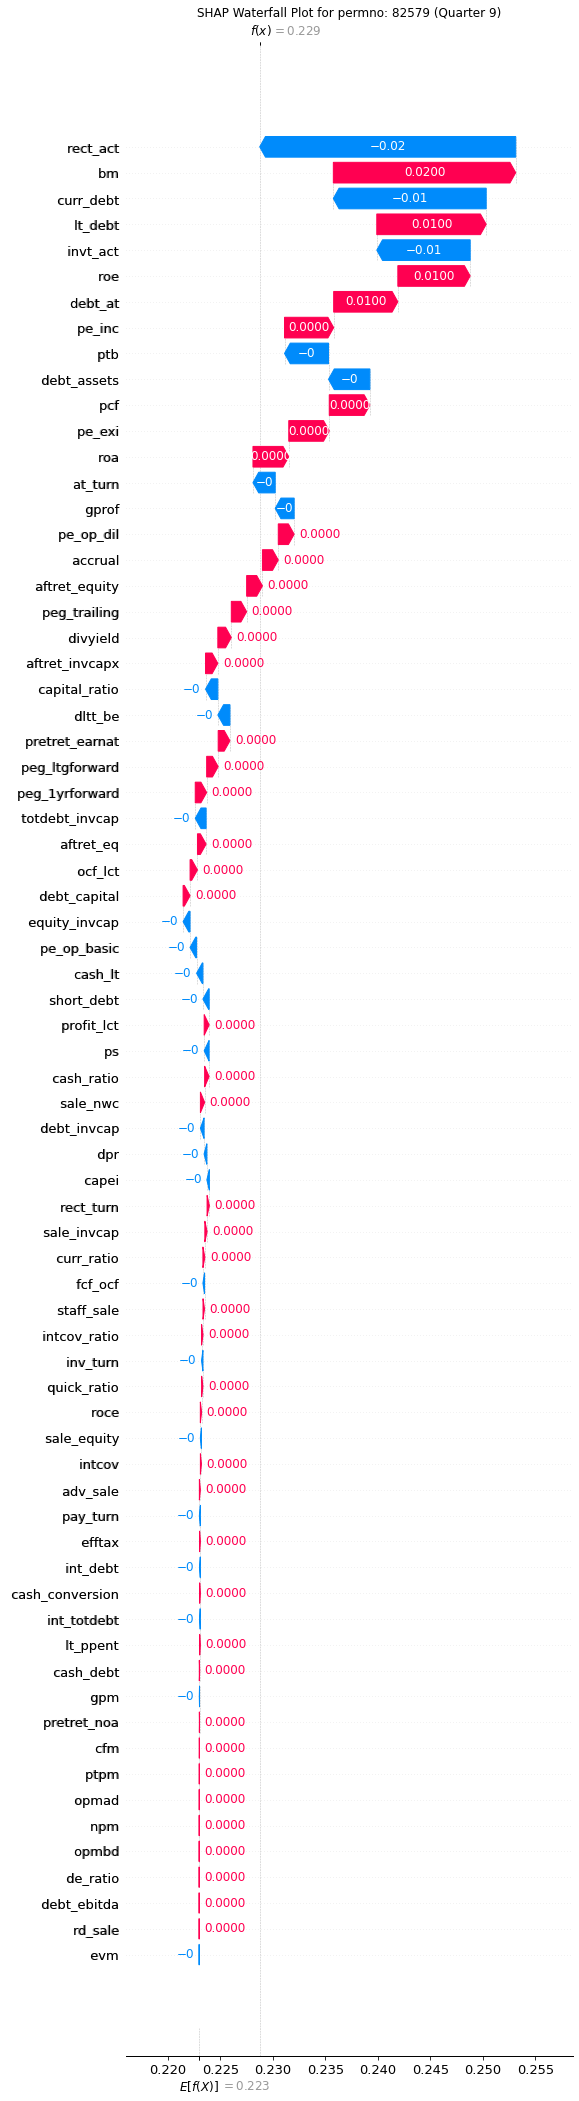

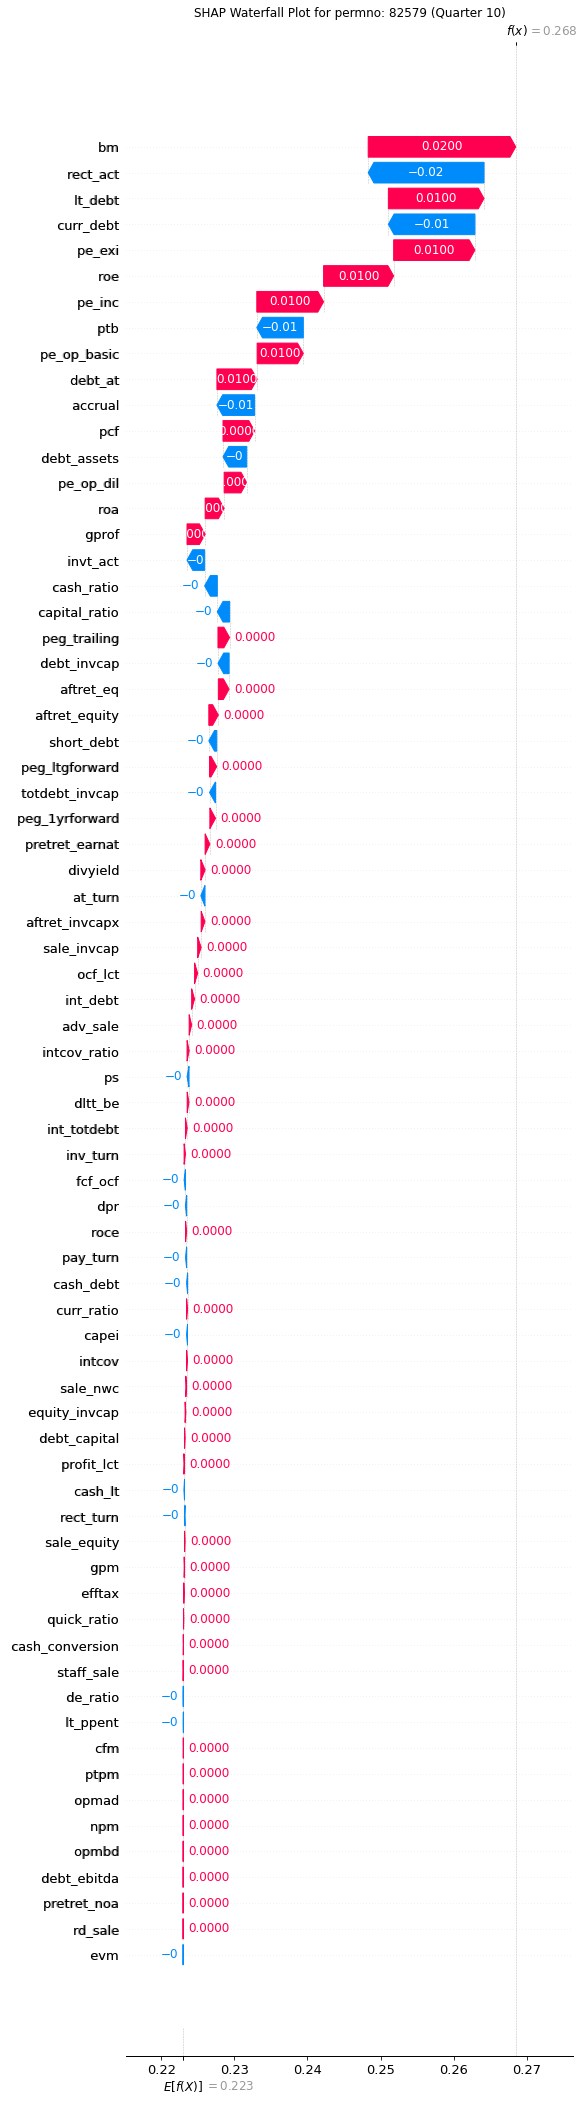

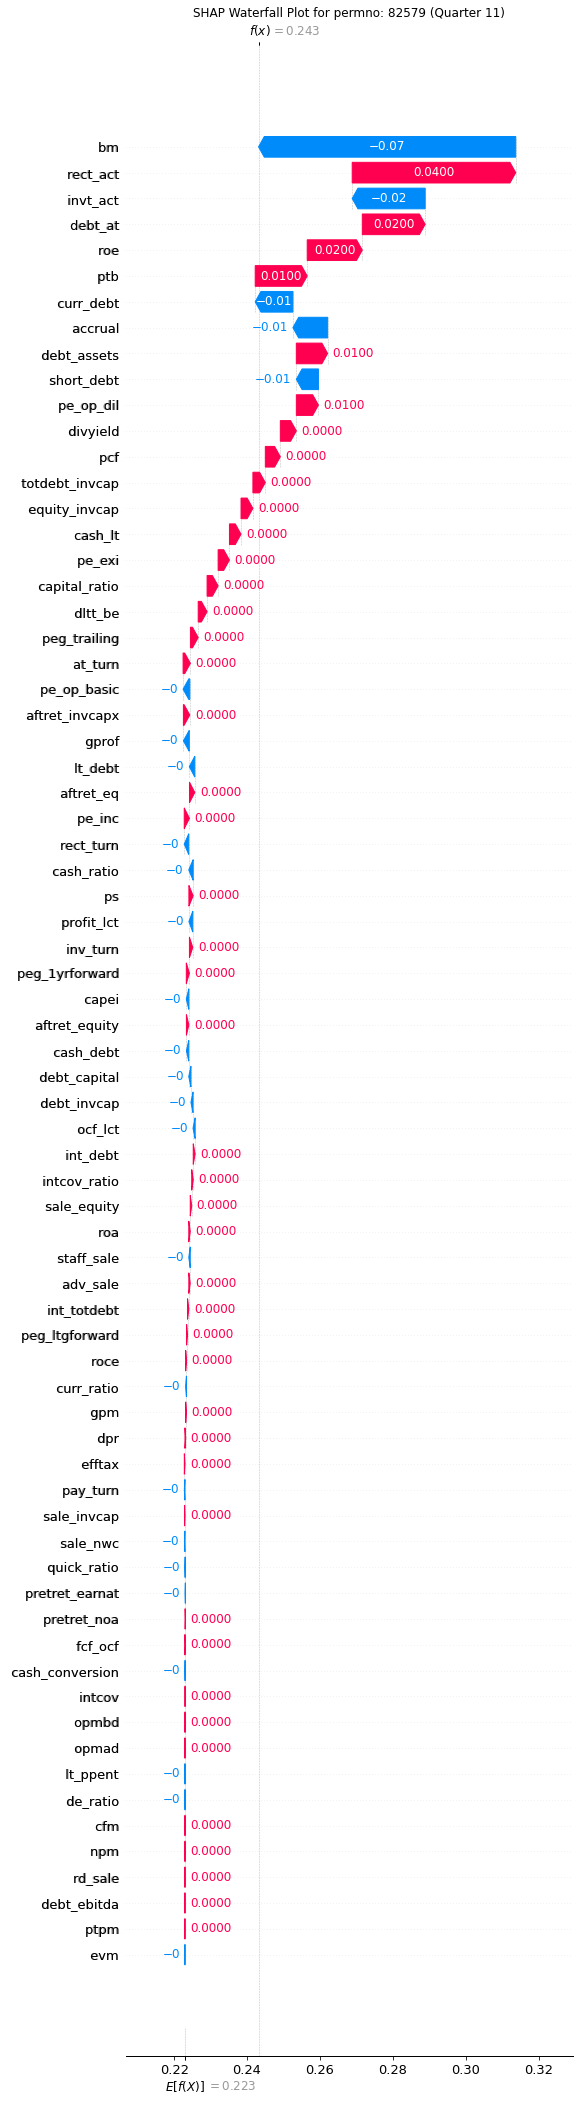

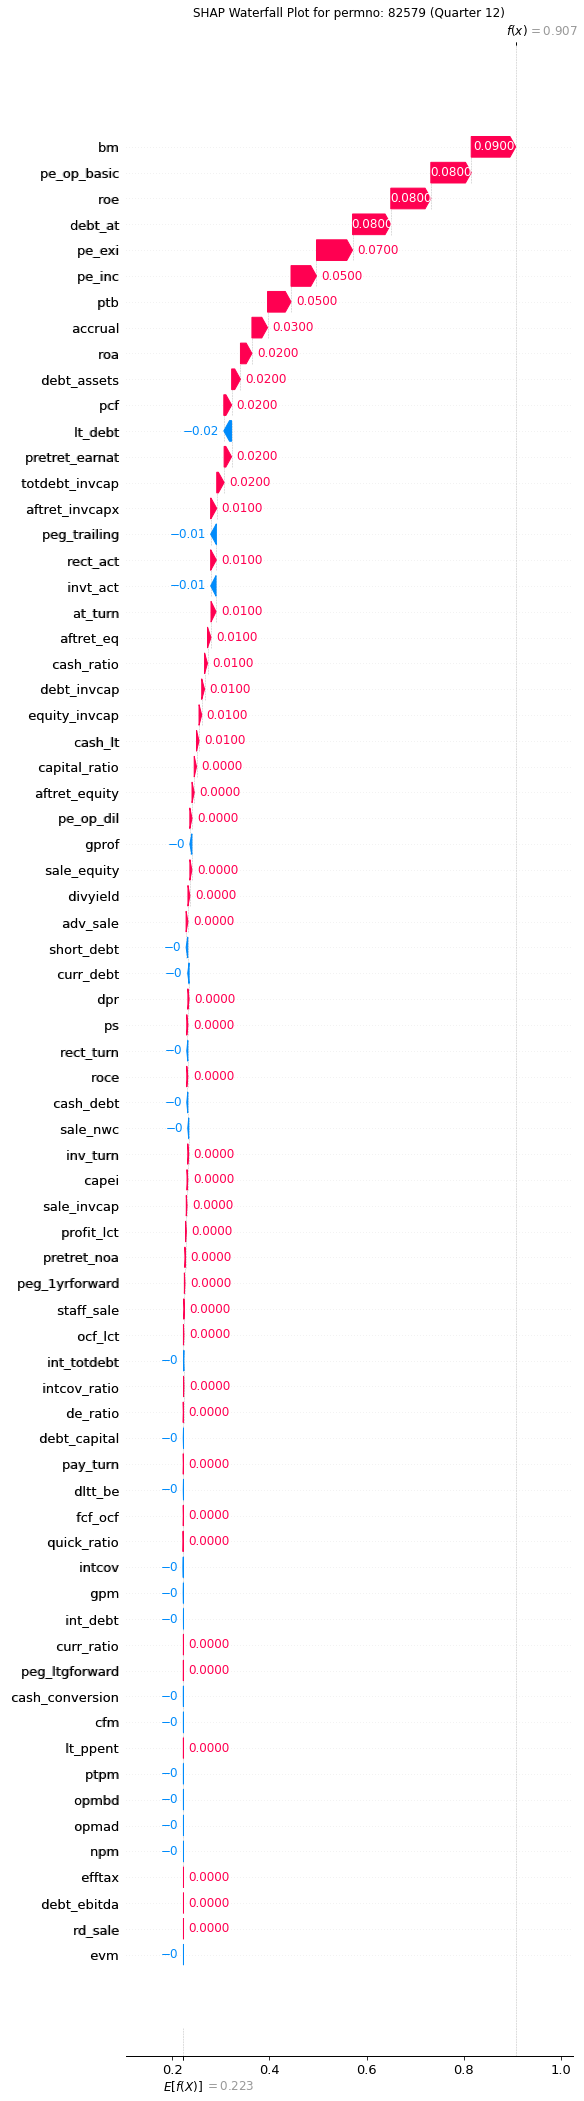

Successfully generated SHAP waterfall plots for permno: 82579


In [31]:
# Function to format the bar values with more precision
def format_bar_labels(ax, precision=4):
    for text in ax.texts:
        try:
            # Check if the text is a number and format it
            value = float(text.get_text())
            text.set_text(f'{value:.{precision}f}')
        except ValueError:
            continue

# Set the desired permno here
desired_permno = 82579

# Find the index of the desired permno in the test_permnos list
if desired_permno in permnos:
    instance_index = permnos.index(desired_permno)
    try:
        shap.initjs()  # Initialize JavaScript visualization in Jupyter notebook

        # Extract feature data
        feature_data = pd.DataFrame(test_data_for_explanation[instance_index], columns=ratios)

        # Generate and plot SHAP waterfall plots for each of the 12 quarters
        for quarter in range(12):
            shap_values_quarter = shap_values[0][instance_index, quarter]

            explanation = shap.Explanation(
                values=shap_values_quarter,  # SHAP values for the current quarter
                base_values=explainer.expected_value[0],  # Assuming single output model
                data=feature_data.iloc[quarter],
                feature_names=ratios
            )

            fig, ax = plt.subplots()
            shap.plots.waterfall(explanation, show=False, max_display=len(ratios))

            # Get current y-tick labels
            yticklabels = ax.get_yticklabels()
            # Extract feature names without the numbers
            new_labels = [label.get_text().split('=')[1].strip() if '=' in label.get_text() else label.get_text() for label in yticklabels]
            
            # Apply new labels
            ax.set_yticklabels(new_labels)

            # Format the bar labels to show more precision
            format_bar_labels(ax, precision=4)

            plt.title(f'SHAP Waterfall Plot for permno: {desired_permno} (Quarter {quarter + 1})')
            plt.show()

        print(f"Successfully generated SHAP waterfall plots for permno: {desired_permno}")

    except Exception as e:
        print(f"Error in generating SHAP waterfall plots for permno: {desired_permno}: {e}")
else:
    print(f"Permno {desired_permno} not found in the test data.")

In [20]:
desired_permno = 89525  # Set the desired permno here

# Find the index of the desired permno in the test_permnos list
if desired_permno in permnos:
    instance_index = permnos.index(desired_permno)
    if instance_index is not None:
        try:
            shap.initjs()  # Initialize JavaScript visualization in Jupyter notebook

            # Data for the instance
            feature_data = test_data_for_explanation[instance_index]

            # Visualize the force plot for the specific instance
            plot = shap.force_plot(
                explainer.expected_value[0],  # Base value from the explainer
                shap_values[0][instance_index],  # SHAP values for the desired instance and class
                feature_data,  # Feature data for the desired instance
                feature_names=ratios  # Names of the features
            )
            
            # Display the plot directly in the notebook
            shap.save_html(f"SHAP_force_plot_permno_{desired_permno}.html", plot)  # Save the plot as an HTML file
            display(plot)
            print(f"Successfully generated SHAP force plot for permno: {desired_permno}")
        except Exception as e:
            print(f"Error in generating SHAP force plot for permno: {desired_permno}: {e}")
else:
    print(f"Permno {desired_permno} not found in the test data.")


Successfully generated SHAP force plot for permno: 89525


In [17]:
# Set the desired permno here
desired_permno = 28193

# Find the index of the desired permno in the test_permnos list
if desired_permno in permnos:
    instance_index = permnos.index(desired_permno)
    if instance_index is not None:
        try:
            shap.initjs()  # Initialize JavaScript visualization in Jupyter notebook

            # Data for the instance
            feature_data = test_data_for_explanation[instance_index, -1, :]  # Use the last timestep
            shap_values_instance = shap_values[0][instance_index, -1, :]  # Use the last timestep

            # Ensure the number of features in `ratios` matches `shap_values`
            num_features = min(len(shap_values_instance), len(ratios))
            top_n = min(10, num_features)  # Limit to the top 10 features or fewer if fewer are available

            # Sort features by absolute SHAP values to get the top `top_n` features
            top_indices = np.argsort(np.abs(shap_values_instance))[-top_n:][::-1]

            # Filter SHAP values and feature data for the top features
            top_shap_values = shap_values_instance[top_indices]
            top_feature_data = feature_data[top_indices]
            top_feature_names = [ratios[i] for i in top_indices]

            # Visualize the force plot for the specific instance
            plot = shap.force_plot(
                explainer.expected_value[0],  # Base value from the explainer
                top_shap_values,  # SHAP values for the desired instance and class
                top_feature_data,  # Feature data for the desired instance
                feature_names=top_feature_names  # Names of the features
            )

            # Save the plot as an HTML file and display
            shap.save_html(f"SHAP_force_plot_permno_{desired_permno}.html", plot)  # Save as HTML
            display(plot)
            print(f"Successfully generated SHAP force plot for permno: {desired_permno}")
        except Exception as e:
            print(f"Error in generating SHAP force plot for permno: {desired_permno}: {e}")
else:
    print(f"Permno {desired_permno} not found in the test data.")

Successfully generated SHAP force plot for permno: 28193


In [ ]:
# Check the shapes
print(f"Shape of `test_data_for_explanation`: {test_data_for_explanation.shape}")
print(f"Length of `ratios`: {len(ratios)}")
print(f"Shape of `shap_values[0]`: {shap_values[0].shape}")


In [74]:
# Extract the expected value (the base value E[f(x)]) for the model output
base_value = explainer.expected_value[0]

# Compute f(x) for each instance
fx_values = [base_value + np.sum(shap_instance[-1]) for shap_instance in shap_values[0]]

# Assuming you have the target values for the test set in `y_test`
# Replace `y_test` with the actual variable holding your target values
original_values = y

# Create a DataFrame with the permno, index, original value (bankrupt or non-bankrupt), and f(x)
fx_df = pd.DataFrame({
    'Index': range(len(fx_values)),
    'permno': permnos,
    'Original Value': original_values,
    'f(x)': fx_values
})

# Save the DataFrame to an Excel file
file_path = 'C:/Users/Roni/fx_values1.xlsx'  # Update to your desired file path
fx_df.to_excel(file_path, index=False)

print(f"Saved f(x) values to {file_path}")


Saved f(x) values to C:/Users/Roni/fx_values1.xlsx


In [16]:
# Extract the expected value (the base value E[f(x)]) for the model output
base_value = explainer.expected_value[0]

# Compute f(x) for each instance
fx_values = [base_value + np.sum(shap_instance[-1]) for shap_instance in shap_values[0]]

# Assuming you have the target values for the test set in `y`
# Replace `y` with the actual variable holding your target values
original_values = y

# Use your model to generate the predicted probabilities or classes
# Replace `model` with your model variable
predictions_prob = model.predict(test_data_for_explanation)  # Assuming binary classification output is 2D
predictions = (predictions_prob > 0.5).astype(int)  # Binary classification with a threshold of 0.5

# Create a DataFrame with the permno, index, original value (bankrupt or non-bankrupt), f(x), and predicted value
fx_df = pd.DataFrame({
    'Index': range(len(fx_values)),
    'permno': permnos,
    'Original Value': original_values,
    'f(x)': fx_values,
    'Predicted Value': predictions.flatten()
})

# Save the DataFrame to an Excel file
file_path = 'C:/Users/Roni/fx_valuesPred.xlsx'  # Update to your desired file path
fx_df.to_excel(file_path, index=False)

print(f"Saved f(x) values to {file_path}")

Saved f(x) values to C:/Users/Roni/fx_valuesPred.xlsx
